# Importing the libs

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


In [4]:
test_df.head()

,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


# EDA

In [5]:
sns.set(style="whitegrid")

## Class Distribution

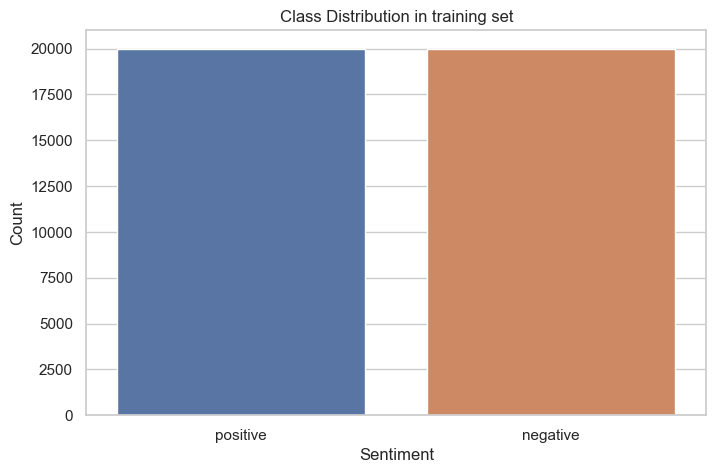

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=train_df, order = train_df['sentiment'].value_counts().index)
plt.title('Class Distribution in training set')
plt.xlabel('Sentiment')
plt.ylabel('Count');

The dataset appears to be perfectly balanced between positive and negative sentiments. Thus, we can proceed without needing to balance our dataset artificially.

## Text Length Analysis

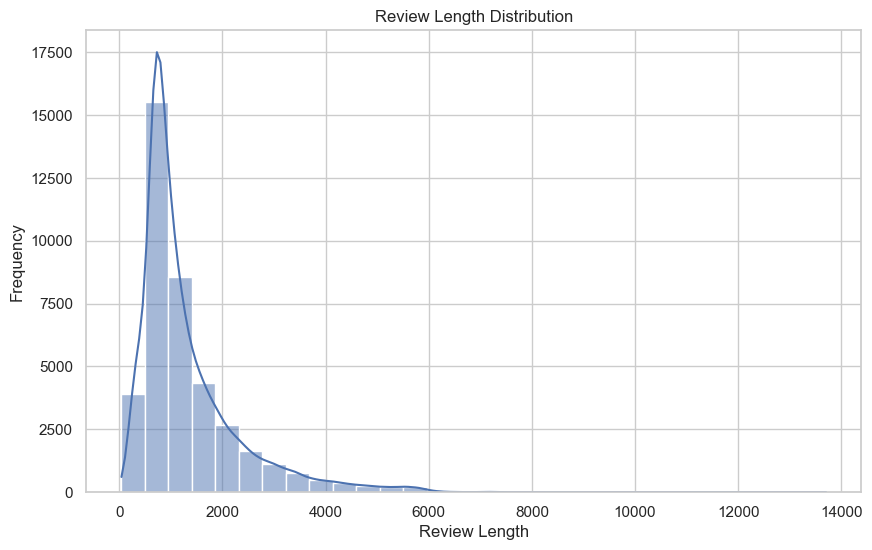

In [7]:
train_df['review_length'] = train_df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['review_length'], bins=30, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency');

The review lengths vary significantly, with a distribution that shows most reviews are under 2000 characters but some extend much longer.

# Data preprocessing

## Tokenization and Stop-Words Filtering

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    
    tokens_filtered = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]

    return " ".join(tokens_filtered)

In [10]:
train_df['processed_review'] = train_df['review'].apply(preprocess_text)

In [11]:
train_df.head()

,review,sentiment,review_length,processed_review
0,I caught this little gem totally by accident b...,positive,892,caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,937,ca believe let movie accomplish favor friends ...
2,*spoiler alert!* it just gets to me the nerve ...,negative,468,spoiler alert gets nerve people remake use ter...
3,If there's one thing I've learnt from watching...,negative,1960,one thing learnt watching george romero creeps...
4,"I remember when this was in theaters, reviews ...",negative,1015,remember theaters reviews said horrible well t...


## Stemming & Lemmatization

In [12]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [14]:
def stem_text(text):
    return " ".join([stemmer.stem(word) for word in word_tokenize(text.lower())])

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text.lower())])

In [15]:
train_df['stemmed_review'] = train_df['processed_review'].apply(stem_text)
train_df['lemmatized_review'] = train_df['processed_review'].apply(lemmatize_text)

In [16]:
train_df['processed_review'][0]

'caught little gem totally accident back revival theatre see two old silly movies theatre packed full warning showed bunch short spoofs get us mood somewhat amusing came within seconds audience hysterics biggest laugh came showed princess laia huge cinnamon buns instead hair head looks camera gives grim smile nods made even funnier got ta see chewabacca played looks like muppet extremely silly stupid could stop laughing dialogue drowned laughter also know star wars pretty well even funnier deliberately poke fun dialogue really works audience definite'

In [17]:
train_df['stemmed_review'][0]

'caught littl gem total accid back reviv theatr see two old silli movi theatr pack full warn show bunch short spoof get us mood somewhat amus came within second audienc hyster biggest laugh came show princess laia huge cinnamon bun instead hair head look camera give grim smile nod made even funnier got ta see chewabacca play look like muppet extrem silli stupid could stop laugh dialogu drown laughter also know star war pretti well even funnier deliber poke fun dialogu realli work audienc definit'

In [18]:
train_df['lemmatized_review'][0]

'caught little gem totally accident back revival theatre see two old silly movie theatre packed full warning showed bunch short spoof get u mood somewhat amusing came within second audience hysteric biggest laugh came showed princess laia huge cinnamon bun instead hair head look camera give grim smile nod made even funnier got ta see chewabacca played look like muppet extremely silly stupid could stop laughing dialogue drowned laughter also know star war pretty well even funnier deliberately poke fun dialogue really work audience definite'

<b>Stemming</b> typically reduces words to their base or root form, often leading to truncated words that may not be actual words. This process is fast and aggressive, making it useful for datasets where the precise form of a word is less important than its root meaning.

<b>Lemmatization</b>, on the other hand, reduces words to their base or dictionary form, ensuring that the reduced form is a valid word. This process is more sophisticated and considers the word's part of speech, making it generally more accurate but slower than stemming.

## TF-IDF Vectorizer & Count Vectorizer

In [19]:
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()

In [20]:
def train_model(vectorizer, X, y):
    X_vectorized = vectorizer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=101)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [21]:
y = train_df['sentiment'].map({'positive': 1, 'negative': 0})  # Assuming binary classification
accuracies = {}
accuracies['TF-IDF Stemmed'] = train_model(tfidf_vectorizer, train_df['stemmed_review'], y)
accuracies['CountVectorizer Stemmed'] = train_model(count_vectorizer, train_df['stemmed_review'], y)
accuracies['TF-IDF Lemmatized'] = train_model(tfidf_vectorizer, train_df['lemmatized_review'], y)
accuracies['CountVectorizer Lemmatized'] = train_model(count_vectorizer, train_df['lemmatized_review'], y)

In [22]:
for method, acc in accuracies.items():
    print(f'{method}: Accuracy = {acc}')

TF-IDF Stemmed: Accuracy = 0.889375
CountVectorizer Stemmed: Accuracy = 0.87425
TF-IDF Lemmatized: Accuracy = 0.887625
CountVectorizer Lemmatized: Accuracy = 0.877375


<h4>Vectorization approaches:</h4>
<body>TF-IDF vs. CountVectorizer: TF-IDF generally performs slightly better than CountVectorizer for both stemmed and lemmatized texts.</body>

<h4>Stemming vs. Lemmatization:</h4>
<body>The differences between stemming and lemmatization in terms of model accuracy are minimal, with stemming slightly outperforming lemmatization when combined with TF-IDF vectorization. This could indicate that the aggressive reduction of words to their stems doesn't significantly detract from the model's ability to classify sentiments, at least for this dataset.</body>

<h3>Conclusion:</h3>
Given these results, we will choose to proceed with TF-IDF vectorization and stemmed text for the highest accuracy. 

In [23]:
test_df.head()

,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


In [24]:
test_df['processed_review'] = test_df['review'].apply(preprocess_text)

test_df['stemmed_review'] = test_df['processed_review'].apply(stem_text)

In [25]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['stemmed_review'])

X_test_tfidf = tfidf_vectorizer.transform(test_df['stemmed_review'])

y_train = train_df['sentiment'].map({'positive': 1, 'negative': 0})

y_test = test_df['sentiment'].map({'positive': 1, 'negative': 0})

# Modeling

In [29]:
def no_tuning(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [30]:
print(no_tuning(LogisticRegression(max_iter=1000),X_train_tfidf,y_train,X_test_tfidf,y_test))

0.8918


We already got the accuracy score higher than 0.85 using <b>Logistic Regression</b> model without any hyperparameter tuning

In [31]:
print(no_tuning(SVC(),X_train_tfidf,y_train,X_test_tfidf,y_test))

0.8968


We got the accuracy score higher than 0.85 using <b>Support Vector Classifier</b> model without any hyperparameter tuning

In [53]:
print(no_tuning(LinearSVC(),X_train_tfidf,y_train,X_test_tfidf,y_test))

0.8908


We got the accuracy score higher than 0.85 using <b>Linear Support Vector Classifier</b> model without any hyperparameter tuning

In [33]:
print(no_tuning(RandomForestClassifier(),X_train_tfidf,y_train,X_test_tfidf,y_test))

0.8541


We got the accuracy score higher than 0.85 using <b>Random Forest Classifier</b> model without any hyperparameter tuning

In conclusion, the SVC model is the best for now but it's very computationally expensive

### LogReg hyperparameter tuning

In [45]:
lr_model = LogisticRegression(max_iter=1000)

In [46]:
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

In [47]:
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5)

In [49]:
lr_grid_search.fit(X_train_tfidf, y_train)
print(f'Best parameters for Logistic Regression: {lr_grid_search.best_params_}')
print(f'Best cross-validation score for Logistic Regression: {lr_grid_search.best_score_}')

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py",

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.888725


In [51]:
y_pred = lr_grid_search.predict(X_test_tfidf)
accuracy_score(y_test,y_pred)

0.8925

The tuned Logistic Regression model is slightly better than non-tuned in terms of accuracy score metric (0.8925 > 0.8918)

### LinearSVC hyperparameter tuning

I tried hyperparameter tuning for SVC and RFC but it took almost a day on my computer, so I wouldn't include it

Instead I'll use the LinearSVC as it is much faster

In [54]:
linear_svc_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'dual': [False]
}

In [55]:
linear_svc_model = LinearSVC(max_iter=10000)

linear_svc_grid_search = GridSearchCV(linear_svc_model, linear_svc_param_grid, cv=5, error_score='raise')

In [56]:
linear_svc_grid_search.fit(X_train_tfidf, y_train)
print('Best parameters for LinearSVC:', linear_svc_grid_search.best_params_)
print('Best cross-validation score for LinearSVC:', linear_svc_grid_search.best_score_)

Best parameters for LinearSVC: {'C': 0.1, 'dual': False, 'penalty': 'l2'}
Best cross-validation score for LinearSVC: 0.8882749999999999


In [57]:
y_pred = linear_svc_grid_search.predict(X_test_tfidf)
accuracy_score(y_test,y_pred)

0.8933

# Conclusion

The LinearSVC model did slightly better compared to Logistic Regression one